<a href="https://colab.research.google.com/github/guyez/NLP/blob/main/Fact_checking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

This assignment is centred on a particular and emerging NLP task, formally known as **fact checking** (or fake checking). As AI techniques become more and more powerful, reaching amazing results, such as image and text generation, it is more than ever necessary to build tools able to distinguish what is real from what is fake.

Here we focus on a small portion of the whole fact checking problem, which aims to determine whether a given statement (fact) conveys a trustworthy information or not. 

More precisely, given a set of evidences and a fact to verify, we would like our model to correctly predict whether the fact is true or fake.

# Import Dependencies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import torch
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, Input 
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, SimpleRNN, GRU, Concatenate, Reshape, Add, Average, Dot, Flatten 

# Reproducibility






In [ ]:
def fix_random(seed):

  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

fix_random(42)

# The FEVER dataset

First of all, we need to choose a dataset. We will rely on the [FEVER dataset](https://fever.ai).

The dataset is about facts taken from Wikipedia documents that have to be verified. In particular, facts could face manual modifications in order to define fake information or to give different formulations of the same concept.

The dataset consists of 185,445 claims manually verified against the introductory sections of Wikipedia pages and classified as ```Supported```, ```Refuted``` or ```NotEnoughInfo```. For the first two classes, systems and annotators need to also return the combination of sentences forming the necessary evidence supporting or refuting the claim.

## Dataset structure

Relevant data is divided into two file types. Information concerning the fact to verify, its verdict and associated supporting/opposing statements are stored in **.jsonl** format. In particular, each JSON element is a python dictionary with the following relevant fields:

*    **ID**: ID associated to the fact to verify.

*    **Verifiable**: whether the fact has been verified or not: ```VERIFIABLE``` or ```NOT VERIFIABLE```.
    
*    **Label**: the final verdict on the fact to verify: ```SUPPORTS```, ```REFUTES``` or ```NOT ENOUGH INFO```.
    
*    **Claim**: the fact to verify.
    
*    **Evidence**: a nested list of document IDs along with the sentence ID that is associated to the fact to verify. In particular, each list element is a tuple of four elements: the first two are internal annotator IDs that can be safely ignored; the third term is the document ID (called URL) and the last one is the sentence number (ID) in the pointed document to consider.

**Some Examples**

---

**Verifiable**

{"id": 202314, "verifiable": "VERIFIABLE", "label": "REFUTES", "claim": "The New Jersey Turnpike has zero shoulders.", "evidence": [[[238335, 240393, "New_Jersey_Turnpike", 15]]]}

---

**Not Verifiable**

{"id": 113501, "verifiable": "NOT VERIFIABLE", "label": "NOT ENOUGH INFO", "claim": "Grease had bad reviews.", "evidence": [[[133128, null, null, null]]]}

---

## Some simplifications and pre-processing

We are only interested in verifiable facts. Thus, we can filter out all non-verifiable claims.

Additionally, the current dataset format does not contain all necessary information for our classification purposes. In particular, we need to download Wikipedia documents and replace reported evidence IDs with the corresponding text.

Don't worry about that! We are providing you the already pre-processed dataset so that you can concentrate on the classification pipeline (pre-processing, model definition, evaluation and training).

You can download the zip file containing all set splits (train, validation and test) of the FEVER dataset by clicking on this [link](https://drive.google.com/file/d/1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1/view?usp=sharing). Alternatively, run the below code cell to automatically download it on this notebook.

**Note**: each dataset split is in .csv format. Feel free to inspect the whole dataset!

In [ ]:
import os
import requests
import zipfile

# download the dataset and save it in the current folder

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Download completed!
Extracting dataset...
Extraction completed!


In [ ]:
# load the train/validation/test splits
train_data = pd.read_csv('dataset/train_pairs.csv',index_col = 0)
val_data = pd.read_csv('dataset/val_pairs.csv',index_col = 0)
test_data = pd.read_csv('dataset/test_pairs.csv',index_col = 0)

In [ ]:
train_data.head()

,Claim,Evidence,ID,Label
0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,3,SUPPORTS
1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,7,SUPPORTS
2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,8,REFUTES
3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,9,SUPPORTS
4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,10,REFUTES


In [ ]:
# dictionary used to replace contractions
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":"we will",
"didn't": "did not"
}

In [ ]:
import re
from functools import reduce

# preprocessing pipeline

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
POS_RE = re.compile('\-LRB\-|\-LSB\-|\-RRB\-|\-RSB\-')
FIRST_NUMBER = re.compile('^[\d-]*\s*')

def remove_after_point(text):
    """
    remove the sentence after the last point
    """
    text = text.split('.')
    if len(text) > 1:
      text = '.'.join(text[:-1])
    else:
      text = text[0]
    return text

def remove_pos(text):
    """ 
    Removes the following pos tags:
    '-LRB-','-LSB-','-RRB-','-RSB-'
    Example:
    Input: 'Greece was the tenth member to join the European Communities -LRB- precursor to the European Union -RRB- and has been part'
    Output: 'Greece was the tenth member to join the European Communities precursor to the European Union and has been part'
    """
    return POS_RE.sub('', text)

def remove_first_number(text):
    """ 
    Removes the first number met in the sentence.
    Example:
    Input: '1	It was written and directed by Karan Johar'
    Output: 'It was written and directed by Karan Johar'
    """
    return FIRST_NUMBER.sub('',text)


def lower(text):
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """
    return text.lower()

def replace_contractions(text):
    """
    replace contractions using the predefined dictionary
    Example:
    Input: 'It wasn't written and directed by Karan Johar'
    Output:'It was not written and directed by Karan Johar'
     """
    words = text.split()
    split = [appos[word] if word in appos else word for word in words]
    return " ".join(split)

def replace_special_characters(text):
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """
    return REPLACE_BY_SPACE_RE.sub(' ', text)

def filter_out_uncommon_symbols(text):
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """
    return GOOD_SYMBOLS_RE.sub('', text)

def strip_text(text):
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """
    text = " ".join(text.split())
    return text.strip()


PREPROCESSING_PIPELINE = [remove_after_point,
                          remove_pos,
                          remove_first_number,
                          lower,
                          replace_contractions,
                          replace_special_characters,
                          filter_out_uncommon_symbols,
                          strip_text]


def text_prepare(text, filter_methods=None):
    """
    Applies a list of pre-processing functions in sequence (reduce).
    """
    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE
    return reduce(lambda txt, f: f(txt), filter_methods, text)

# Pre-processing

print('Pre-processing text...')

print()
print('[Debug] Before:\nClaim: {}'.format(train_data['Claim'].iloc[42]))
print('Evidence: {}'.format(train_data['Evidence'].iloc[42]))

print()

# Replace each sentence with its pre-processed version (train set)
train_data['Claim'] = train_data['Claim'].apply(lambda txt: text_prepare(txt))
train_data['Evidence'] = train_data['Evidence'].apply(lambda txt: text_prepare(txt))

# Replace each sentence with its pre-processed version (val set)
val_data['Claim'] = val_data['Claim'].apply(lambda txt: text_prepare(txt))
val_data['Evidence'] = val_data['Evidence'].apply(lambda txt: text_prepare(txt))

# Replace each sentence with its pre-processed version (test set)
test_data['Claim'] = test_data['Claim'].apply(lambda txt: text_prepare(txt))
test_data['Evidence'] = test_data['Evidence'].apply(lambda txt: text_prepare(txt))


print('[Debug] After:\nClaim: {}'.format(train_data['Claim'].iloc[42]))
print('Evidence: {}'.format(train_data['Evidence'].iloc[42]))

print()

print("Pre-processing completed!")

Pre-processing text...

[Debug] Before:
Claim: World War II took place on Earth.
Evidence: 8	The Empire of Japan aimed to dominate Asia and the Pacific and was already at war with the Republic of China in 1937 , but the world war is generally said to have begun on 1 September 1939 with the invasion of Poland by Nazi Germany and subsequent declarations of war on Germany by France and the United Kingdom .	Pacific	Pacific Ocean	China	Second Sino-Japanese War	Nazi Germany	Nazi Germany	Empire of Japan	Empire of Japan	Asia	Asia	at war	Second Sino-Japanese War	Republic of China	Republic of China (1912–49)	invasion	invasion of Poland	Poland	Soviet invasion of Poland	France	French Third Republic	United Kingdom	United Kingdom	Japan	Empire of Japan

[Debug] After:
Claim: world war ii took place on earth
Evidence: the empire of japan aimed to dominate asia and the pacific and was already at war with the republic of china in 1937 but the world war is generally said to have begun on 1 september 1939

In [ ]:
train_data.head()

,Claim,Evidence,ID,Label
0,chris hemsworth appeared in a perfect getaway,hemsworth has also appeared in the science fic...,3,SUPPORTS
1,roald dahl is a writer,roald dahl langpronrold _ dl ul dl 13 septembe...,7,SUPPORTS
2,roald dahl is a governor,roald dahl langpronrold _ dl ul dl 13 septembe...,8,REFUTES
3,ireland has relatively lowlying mountains,the island s geography comprises relatively lo...,9,SUPPORTS
4,ireland does not have relatively lowlying moun...,the island s geography comprises relatively lo...,10,REFUTES


## Distribution of labels in training, validation and test sets

It can be noticed that in training set labels are imbalanced

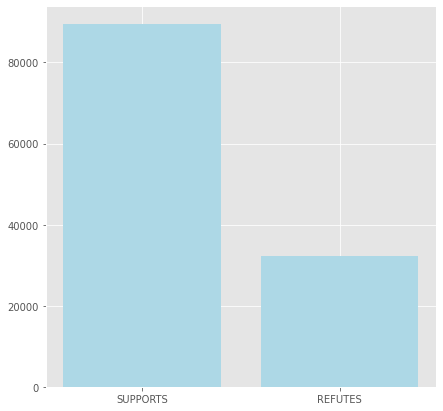

In [ ]:
plt.style.use('ggplot')

labels_count = train_data.groupby('Label').agg('count')

counts = [labels_count.Claim[1], labels_count.Claim[0]]
labels = ["SUPPORTS", "REFUTES"]

plt.figure(figsize = (7,7))
plt.bar(labels, counts, align='center', color = "lightblue")
plt.gca().set_xticks(labels)

plt.show()

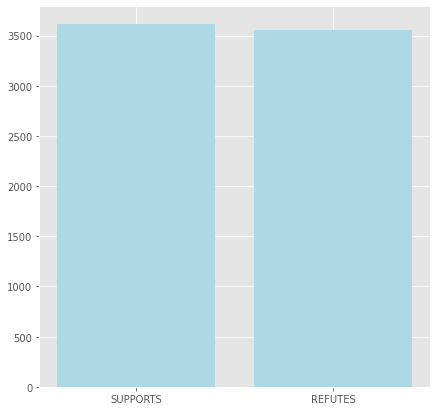

In [ ]:
labels_count = val_data.groupby('Label').agg('count')

counts = [labels_count.Claim[1], labels_count.Claim[0]]

plt.figure(figsize = (7,7))
plt.bar(labels, counts, align='center', color = "lightblue")
plt.gca().set_xticks(labels)

plt.show()

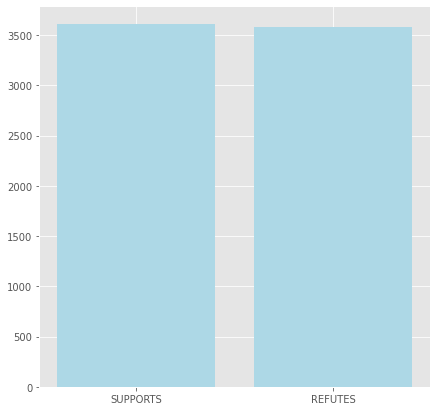

In [ ]:
labels_count = test_data.groupby('Label').agg('count')

counts = [labels_count.Claim[1], labels_count.Claim[0]]

plt.figure(figsize = (7,7))
plt.bar(labels, counts, align='center', color = "lightblue")
plt.gca().set_xticks(labels)

plt.show()

In [ ]:
# group the data by their ID to count the number of evidences for each claim
evidence_count = train_data.groupby('ID').agg('count')
evidence_count[evidence_count.Claim != 1].sort_values(ascending = False,by = 'Claim')

,Claim,Evidence,Label
ID,,,
78898,16,16,16
224231,13,13,13
213773,12,12,12
114223,12,12,12
121823,11,11,11
...,...,...,...
76417,2,2,2
76424,2,2,2
76431,2,2,2


In [ ]:
print("Only {} out of {} claims have more than one evidence".format(len(evidence_count[evidence_count.Claim != 1]), len(evidence_count)))

Only 11342 out of 109091 claims have more than one evidence


In [ ]:
import gensim
import gensim.downloader as gloader
import pickle

def load_embedding_model(embedding_dimension=50):
    """
    Loads a pre-trained word embedding model via gensim library.
    :param embedding_dimension: size of the embedding space to consider
    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

embedding_dimension = 200

# download and save the glove model
glove_folder = os.path.join(os.getcwd(), "glove")

if not os.path.exists(glove_folder):
    os.makedirs(glove_folder)
glove_file = os.path.join(glove_folder, "glove{}.pkl".format(embedding_dimension))

if not os.path.isfile(glove_file):
    embedding_model = load_embedding_model(embedding_dimension)
    pickle.dump(embedding_model, open(glove_file, 'wb'))
else:
    # load the model from disk
    embedding_model = pickle.load(open(glove_file, 'rb'))  

[==================================================] 100.0% 252.1/252.1MB downloaded


# Build vocabulary

In [ ]:
# create the vocabulary by using the whole dataset
df = pd.concat([train_data, val_data, test_data])

text = df['Claim'].append( df['Evidence'], ignore_index=True)

tokenizer = Tokenizer()

tokenizer.fit_on_texts(text)
    
word_index = tokenizer.word_index
    
vocab_size = len(word_index)

print('[Debug] Word -> Index vocabulary size: {}'.format(len(word_index)))
print('[Debug] Vocabulary words: {}\n\n'.format(word_index.items()))

[Debug] Word -> Index vocabulary size: 39398
[Debug] Vocabulary words: dict_items([('the', 1), ('and', 2), ('in', 3), ('a', 4), ('of', 5), ('is', 6), ('was', 7), ('by', 8), ('an', 9), ('film', 10), ('as', 11), ('to', 12), ('for', 13), ('american', 14), ('on', 15), ('born', 16), ('with', 17), ('has', 18), ('s', 19), ('from', 20), ('his', 21), ('he', 22), ('series', 23), ('television', 24), ('known', 25), ('actor', 26), ('directed', 27), ('award', 28), ('united', 29), ('at', 30), ('best', 31), ('it', 32), ('her', 33), ('states', 34), ('first', 35), ('which', 36), ('that', 37), ('released', 38), ('one', 39), ('who', 40), ('or', 41), ('also', 42), ('actress', 43), ('she', 44), ('world', 45), ('album', 46), ('written', 47), ('drama', 48), ('films', 49), ('producer', 50), ('stars', 51), ('john', 52), ('its', 53), ('awards', 54), ('are', 55), ('won', 56), ('city', 57), ('not', 58), ('singer', 59), ('based', 60), ('role', 61), ('name', 62), ('comedy', 63), ('academy', 64), ('new', 65), ('2016'

In [ ]:
# substitute words with their indexes
claim_sentences_train = tokenizer.texts_to_sequences(train_data.Claim)
evidence_sentences_train = tokenizer.texts_to_sequences(train_data.Evidence)

claim_sentences_val = tokenizer.texts_to_sequences(val_data.Claim)
evidence_sentences_val = tokenizer.texts_to_sequences(val_data.Evidence)

claim_sentences_test = tokenizer.texts_to_sequences(test_data.Claim)
evidence_sentences_test = tokenizer.texts_to_sequences(test_data.Evidence)

# Padding

In [ ]:
def find_max_list(list):
    """Find the sentence with max length.
    Args:
        list: A list of claims/sentences.

    Returns:
        The max length of a sentence in the given list.
    """
    list_len = [len(i) for i in list]
    return max(list_len)

max_len_train = max(find_max_list(evidence_sentences_train),
                    find_max_list(claim_sentences_train))
max_len_val = max(find_max_list(evidence_sentences_val),
                    find_max_list(claim_sentences_val))
max_len_test = max(find_max_list(evidence_sentences_test), find_max_list(claim_sentences_test))

max_len = max(max_len_train, max_len_val, max_len_test)

# perform padding to the 3 sets
claim_train = pad_sequences(claim_sentences_train, maxlen=max_len)
evidence_train = pad_sequences(evidence_sentences_train, maxlen=max_len)

claim_val = pad_sequences(claim_sentences_val, maxlen=max_len)
evidence_val = pad_sequences(evidence_sentences_val, maxlen=max_len)

claim_test = pad_sequences(claim_sentences_test, maxlen=max_len)
evidence_test = pad_sequences(evidence_sentences_test, maxlen=max_len)


# show one random example
print("Max sentence length is: ", max_len)

random_idx = np.random.randint(len(train_data.Claim))

print("Claim example: ", train_data.Claim[random_idx])
print("Claim train example: ", claim_train[random_idx])

print("Evidence example: ",train_data.Evidence[random_idx])
print("Evidence train example: ", evidence_train[random_idx])

print("Support or not: ", train_data.Label[random_idx])

Max sentence length is:  203
Claim example:  gary ridgway was born on february 18 1949
Claim train example:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    

# Build embedding matrix
Using random vectors for OOV words

In [ ]:
def build_embedding_matrix(word_index):
    """Build the embedding matrix.
    Args:
        word_index: the vocabulary.

    Returns:
        The embedding matrix.
    """
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dimension))

    # count the number of OOV terms
    oov_len = 0

    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_model[word]
        except:
            embedding_matrix[i] = np.random.normal(embedding_dimension) 
            oov_len += 1

    print("Total OOV terms: {0} ({1:.2f}%)".format(oov_len, oov_len / vocab_size * 100))
    return embedding_matrix

embedding_matrix = build_embedding_matrix(word_index)

Total OOV terms: 6857 (17.40%)


# Create the model

In [ ]:
def get_model(name, merging="concat", cosine=False):
  """Function used to build the model according to the chosen strategies.
  Args:
      name: Name of the encoding strategy.
      merging: Name of the merging strategy.
      cosine: Boolean to indicate wether using the cosine similarity feature. 

  Returns:
      The model.
  """

  claim_inputs = Input(shape=(None,))
  evidence_inputs = Input(shape=(None,))
  
  # embedding
  claim_embedding = Embedding(input_dim = vocab_size + 1, 
                        output_dim = embedding_dimension, 
                        weights = [embedding_matrix],
                        trainable = False,
                        mask_zero = True)(claim_inputs)
  evidence_embedding = Embedding(input_dim = vocab_size + 1, 
                        output_dim = embedding_dimension,  
                        weights = [embedding_matrix],
                        trainable = False,
                        mask_zero = True)(evidence_inputs)

  # encoding

  # to make all encoding strategies have the same output size
  # in this way we can make sure that the diff results are from diff strategies
  encoding_dimension = embedding_dimension 
    
  if name.strip().lower() == "rnn":
    gru_layer = GRU(encoding_dimension)
    claim_encode = gru_layer(claim_embedding)
    evidence_encode = gru_layer(evidence_embedding)

  elif name.strip().lower() == "rnn_avg":
    lstm_layer = LSTM(encoding_dimension, return_sequences=True, return_state=True)
    lstm_claim,_,_ = lstm_layer(claim_embedding)
    lstm_evidence, _, _ = lstm_layer(evidence_embedding)
    claim_encode = tf.reduce_mean(lstm_claim, axis=1)
    evidence_encode = tf.reduce_mean(lstm_evidence, axis=1)

  elif name.strip().lower() == "mlp":
    claim_encode = Reshape((max_len * embedding_dimension, ))(claim_embedding)
    claim_encode = Dense(encoding_dimension, activation = 'relu')(claim_encode)
    evidence_encode = Reshape((max_len * embedding_dimension, ))(evidence_embedding)
    evidence_encode = Dense(encoding_dimension, activation = 'relu')(evidence_encode)

  elif name.strip().lower() == "bov":
    claim_encode = tf.reduce_mean(claim_embedding, axis=1)
    evidence_encode = tf.reduce_mean(evidence_embedding, axis=1)

  else:
    raise AttributeError("Unsupported model type! Available ones: rnn, rnn_avg, mlp, bov")

  # merging
  if merging.strip().lower() == "concat":
    encode = Concatenate()([claim_encode, evidence_encode])

  elif merging.strip().lower() == "sum":
    encode = Add()([claim_encode, evidence_encode])

  elif merging.strip().lower() == "avg":
    encode = Average()([claim_encode, evidence_encode])

  else:
   raise AttributeError("Unsupported merging method! Available ones: concat, sum, avg")

  if cosine:
    cosine_similarity = Dot(axes = 1, normalize = True)([claim_inputs, evidence_inputs])
    encode = Concatenate()([encode, cosine_similarity])
  
  # classifier
  outputs = Dense(64, activation='relu')(encode)
  outputs = Dense(1, activation='sigmoid')(outputs)

  # create the model
  model = Model(inputs=[claim_inputs, evidence_inputs], outputs=outputs)

  return model

In [ ]:
y_train = np.asarray([1 if label=='SUPPORTS' else 0 for label in train_data.Label])
y_val   = np.asarray([1 if label=='SUPPORTS' else 0 for label in val_data.Label])
y_test  = np.asarray([1 if label=='SUPPORTS' else 0 for label in test_data.Label])

print(train_data.Label[:10])
print(y_train[:10])

0    SUPPORTS
1    SUPPORTS
2     REFUTES
3    SUPPORTS
4     REFUTES
5    SUPPORTS
6    SUPPORTS
7    SUPPORTS
8    SUPPORTS
9    SUPPORTS
Name: Label, dtype: object
[1 1 0 1 0 1 1 1 1 1]


In [ ]:
from imblearn.over_sampling import RandomOverSampler

# balance the training dataset according to the labels, since we have seen in the histograms
# above that the output labels were strongly unbalanced with respect to validation and test set. 

over = RandomOverSampler()
X_train = np.concatenate((claim_train, evidence_train), axis = -1)
X_train, y_train = over.fit_resample(X_train, y_train)

claim_train = X_train[:,:max_len_train]
evidence_train = X_train[:,max_len_train:]

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


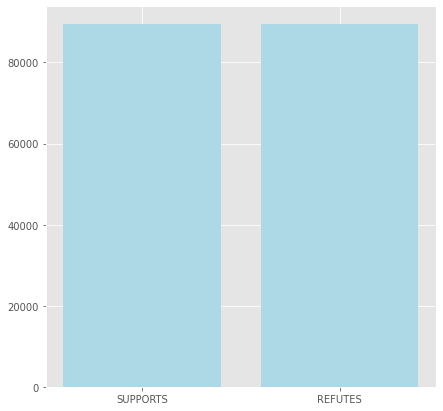

In [ ]:
counts = [len(y_train[y_train == 1]), len(y_train[y_train == 0])]

plt.figure(figsize = (7,7))
plt.bar(labels, counts, align='center', color = "lightblue")
plt.gca().set_xticks(labels)

plt.show()

In [ ]:
#function used to look at the training history
def plot_history(history):
    """Plot the training history.
    Args:
        history: the training history.
    """
    train_acc = history.history['acc']
    train_loss = history.history['loss']
    val_acc = history.history['val_acc']
    val_loss = history.history['val_loss']
    
    epochs = range(len(train_acc))
    plt.plot(epochs, train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, train_loss, 'g', label='Training Loss')
    plt.plot(epochs, val_acc, 'r', label='Valid accuracy')
    plt.plot(epochs, val_loss, 'y', label='Valid Loss')
    
    plt.legend()
    plt.show()

# Compare the models
In this section we have compared all the different encoding and merging strategies and also the cosine similarity extension.

## Encoding strategies
Train the models with the 4 different encoding strategies and using the same merging strategy for everyone (concat), then compare their f1 score on validation set.

After several experiments we have found that the best encoding strategy is the one that uses as sentence embedding the last state of a RNN, in our case a GRU layer, with an F1 score on the validation set of 76%.

Overall results:

|  Model  |  Val.Accuracy | F1 score |
|:-------:|:-------------:|:--------:|
|   rnn   |     76.9%     |   0.755  |
| rnn_avg |     73.9%     |   0.736  |
|   mlp   |     63.9%     |   0.632  |
|   bov   |     61.5%     |   0.608  |
 





In [ ]:
model_rnn = get_model("rnn")

# compile model
model_rnn.compile(loss='mean_squared_error', optimizer='adam', metrics= ['acc'])

# check summary of the model
model_rnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    7879800     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    7879800     input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)

history = model_rnn.fit([claim_train, evidence_train], y_train, batch_size=1024, epochs=10, verbose=1,
                    validation_data = ([claim_val, evidence_val], y_val),callbacks = callback)

Epoch 1/10
175/175 [==============================] - 166s 908ms/step - loss: 0.2106 - acc: 0.6466 - val_loss: 0.1719 - val_acc: 0.7361
Epoch 2/10
175/175 [==============================] - 156s 892ms/step - loss: 0.1462 - acc: 0.7846 - val_loss: 0.1614 - val_acc: 0.7570
Epoch 3/10
175/175 [==============================] - 155s 888ms/step - loss: 0.1259 - acc: 0.8192 - val_loss: 0.1592 - val_acc: 0.7580
Epoch 4/10
175/175 [==============================] - 155s 886ms/step - loss: 0.1099 - acc: 0.8484 - val_loss: 0.1586 - val_acc: 0.7692
Epoch 5/10
175/175 [==============================] - 155s 886ms/step - loss: 0.0954 - acc: 0.8717 - val_loss: 0.1691 - val_acc: 0.7626
Epoch 6/10
175/175 [==============================] - 155s 886ms/step - loss: 0.0826 - acc: 0.8926 - val_loss: 0.1719 - val_acc: 0.7630
Epoch 7/10
175/175 [==============================] - 155s 885ms/step - loss: 0.0708 - acc: 0.9113 - val_loss: 0.1821 - val_acc: 0.7591


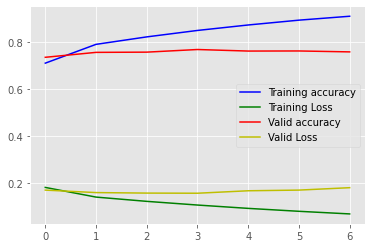

In [ ]:
plot_history(history)

In [ ]:
model_rnn_avg = get_model("rnn_avg")

# compile model
model_rnn_avg.compile(loss='mean_squared_error', optimizer='adam', metrics= ['acc'])

# check summary of the model
model_rnn_avg.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 200)    7879800     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 200)    7879800     input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
history = model_rnn_avg.fit([claim_train, evidence_train], y_train, batch_size=1024, epochs=10, verbose=1,
                    validation_data = ([claim_val, evidence_val], y_val),callbacks = callback)

Epoch 1/10
175/175 [==============================] - 155s 854ms/step - loss: 0.2317 - acc: 0.5962 - val_loss: 0.1908 - val_acc: 0.6962
Epoch 2/10
175/175 [==============================] - 147s 840ms/step - loss: 0.1718 - acc: 0.7360 - val_loss: 0.1796 - val_acc: 0.7235
Epoch 3/10
175/175 [==============================] - 147s 841ms/step - loss: 0.1554 - acc: 0.7689 - val_loss: 0.1748 - val_acc: 0.7302
Epoch 4/10
175/175 [==============================] - 147s 842ms/step - loss: 0.1413 - acc: 0.7965 - val_loss: 0.1736 - val_acc: 0.7387
Epoch 5/10
175/175 [==============================] - 147s 840ms/step - loss: 0.1298 - acc: 0.8166 - val_loss: 0.1808 - val_acc: 0.7322
Epoch 6/10
175/175 [==============================] - 147s 839ms/step - loss: 0.1193 - acc: 0.8344 - val_loss: 0.1800 - val_acc: 0.7397
Epoch 7/10
175/175 [==============================] - 146s 837ms/step - loss: 0.1092 - acc: 0.8516 - val_loss: 0.1831 - val_acc: 0.7361
Epoch 8/10
175/175 [============================

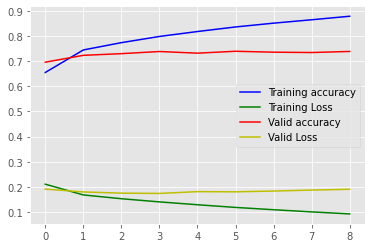

In [ ]:
plot_history(history)

In [ ]:
model_mlp = get_model("mlp")

# compile model
model_mlp.compile(loss='mean_squared_error', optimizer='adam', metrics= ['acc'])

# check summary of the model
model_mlp.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, None, 200)    7879800     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 200)    7879800     input_6[0][0]                    
____________________________________________________________________________________________

In [ ]:
history = model_mlp.fit([claim_train, evidence_train], y_train, batch_size=1024, epochs=10, verbose=1,
                    validation_data = ([claim_val, evidence_val], y_val),callbacks = callback)

Epoch 1/10
175/175 [==============================] - 17s 94ms/step - loss: 0.3055 - acc: 0.6160 - val_loss: 0.3100 - val_acc: 0.6294
Epoch 2/10
175/175 [==============================] - 16s 92ms/step - loss: 0.2556 - acc: 0.7130 - val_loss: 0.3118 - val_acc: 0.6299
Epoch 3/10
175/175 [==============================] - 16s 94ms/step - loss: 0.2367 - acc: 0.7450 - val_loss: 0.3123 - val_acc: 0.6388
Epoch 4/10
175/175 [==============================] - 16s 94ms/step - loss: 0.2180 - acc: 0.7723 - val_loss: 0.3178 - val_acc: 0.6363
Epoch 5/10
175/175 [==============================] - 16s 92ms/step - loss: 0.2107 - acc: 0.7821 - val_loss: 0.3210 - val_acc: 0.6318
Epoch 6/10
175/175 [==============================] - 16s 92ms/step - loss: 0.2035 - acc: 0.7917 - val_loss: 0.3241 - val_acc: 0.6327


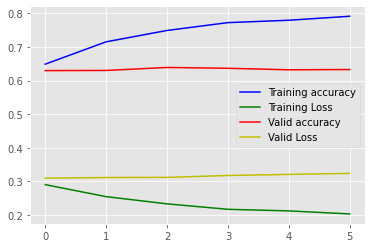

In [ ]:
plot_history(history)

In [ ]:
model_bov = get_model("bov")

# compile model
model_bov.compile(loss='mean_squared_error', optimizer='adam', metrics= ['acc'])

# check summary of the model
model_bov.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 200)    7879800     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 200)    7879800     input_8[0][0]                    
____________________________________________________________________________________________

In [ ]:
history = model_bov.fit([claim_train, evidence_train], y_train, batch_size=128, epochs=10, verbose=1,
                    validation_data = ([claim_val, evidence_val], y_val),callbacks = callback)

Epoch 1/10
1397/1397 [==============================] - 18s 12ms/step - loss: 0.2476 - acc: 0.5521 - val_loss: 0.2350 - val_acc: 0.5768
Epoch 2/10
1397/1397 [==============================] - 17s 12ms/step - loss: 0.2284 - acc: 0.6047 - val_loss: 0.2296 - val_acc: 0.5869
Epoch 3/10
1397/1397 [==============================] - 17s 12ms/step - loss: 0.2226 - acc: 0.6144 - val_loss: 0.2272 - val_acc: 0.5941
Epoch 4/10
1397/1397 [==============================] - 17s 12ms/step - loss: 0.2197 - acc: 0.6188 - val_loss: 0.2249 - val_acc: 0.5994
Epoch 5/10
1397/1397 [==============================] - 17s 12ms/step - loss: 0.2167 - acc: 0.6237 - val_loss: 0.2232 - val_acc: 0.6078
Epoch 6/10
1397/1397 [==============================] - 17s 12ms/step - loss: 0.2147 - acc: 0.6279 - val_loss: 0.2219 - val_acc: 0.6057
Epoch 7/10
1397/1397 [==============================] - 18s 13ms/step - loss: 0.2131 - acc: 0.6307 - val_loss: 0.2207 - val_acc: 0.6091
Epoch 8/10
1397/1397 [==========================

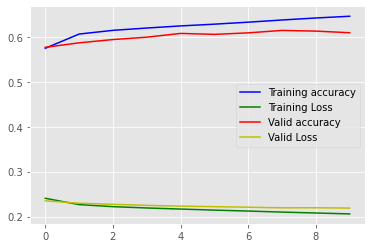

In [ ]:
plot_history(history)

In [ ]:
from sklearn.metrics import f1_score

def F1_score(model, x_test, model_name):
  """Function used to compute and print the F1 score.
  Args:
      model: the model.
      x_test: test data.
      model_name: name of the model.

  Returns:
      F1 score.
  """
  y_pred = model.predict(x_test)
  out = [1 if x>=0.5 else 0 for x in y_pred]
  f1_macro_score = f1_score(y_val, out, labels=[0,1], average="macro", zero_division=0)
  print("{} model's F1 Macro score: {:.4f}".format(model_name, f1_macro_score))
  return f1_macro_score

In [ ]:
# compute the F1 score of the 4 models and compare them to choose the best one
models_list = [model_rnn, model_rnn_avg, model_mlp, model_bov]
models_list_name = ['rnn', 'rnn_avg', 'mlp', 'bov']

best_f1_score = 0
best_concat_model_index = 0

for i, model in enumerate(models_list):
  f1 = F1_score(model, [claim_val, evidence_val], models_list_name[i])
  if f1 > best_f1_score:
    best_f1_score = f1
    best_concat_model_index = i

print("The best f1 score was achieved by the {} model with a score of: {}".format(models_list_name[best_concat_model_index], best_f1_score))

rnn model's F1 Macro score: 0.7555
rnn_avg model's F1 Macro score: 0.7362
mlp model's F1 Macro score: 0.6323
bov model's F1 Macro score: 0.6084
The best f1 score was achieved by the rnn model with a score of: 0.7554597837521455


## Merging strategies
Compare the different merging strategies on the model with the best encoding strategy.

From the table below it can be easily seen that the best merging strategy is the concatenation one.

| Merging Strategy | Val.Accuracy | F1 score |
|:----------------:|:------------:|:--------:|
|      concat      |     76.9%    |   0.755  |
|        sum       |     75.3%    |   0.749  |
|        avg       |     75.2%    |   0.748  |

In [ ]:
# get the best model
best_model_name = models_list_name[best_concat_model_index]
best_model = models_list[best_concat_model_index]

# initialize the best merging strategy 
best_merging = 'concat'

merging_name = ['sum', 'avg']

for merging in merging_name:
  model = get_model(best_model_name, merging = merging)

  # compile model
  model.compile(loss='mean_squared_error', optimizer='adam', metrics= ['acc'])

  # check summary of the model
  model.summary()
  print()
  print("Training of the model with {} merging strategy\n".format(merging))
  history = model.fit([claim_train, evidence_train], y_train, batch_size=1024, epochs=10, verbose=1,
                    validation_data = ([claim_val, evidence_val], y_val),callbacks = callback)
  print()
  print()
  f1 = F1_score(model,[claim_val,evidence_val], merging)
  if f1 > best_f1_score:
    best_f1_score = f1
    best_merging = merging
    best_model = model

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, None, 200)    7879800     input_15[0][0]                   
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, None, 200)    7879800     input_16[0][0]                   
____________________________________________________________________________________________

In [ ]:
print("The best f1 score was achieved by the model with {} merging strategy with a score of: {}".format(best_merging, best_f1_score))

The best f1 score was achieved by the model with concat merging strategy with a score of: 0.7560600260345487


## Cosine similarity extension
Try the cosine similarity feature in the encoding.

From the eperiments we have done we can say that it does not cause significnt difference.

In [ ]:
model_cos = get_model(best_model_name, cosine = True, merging = best_merging)

# compile model
model_cos.compile(loss='mean_squared_error', optimizer='adam', metrics= ['acc'])

# check summary of the model
model_cos.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, None, 200)    7879800     input_19[0][0]                   
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, None, 200)    7879800     input_20[0][0]                   
____________________________________________________________________________________________

In [ ]:
history = model_cos.fit([claim_train, evidence_train], y_train, batch_size=1024, epochs=10, verbose=1,
                    validation_data = ([claim_val, evidence_val], y_val),callbacks = callback)

Epoch 1/10
175/175 [==============================] - 163s 904ms/step - loss: 0.2063 - acc: 0.6584 - val_loss: 0.1711 - val_acc: 0.7404
Epoch 2/10
175/175 [==============================] - 156s 892ms/step - loss: 0.1462 - acc: 0.7844 - val_loss: 0.1625 - val_acc: 0.7498
Epoch 3/10
175/175 [==============================] - 157s 899ms/step - loss: 0.1272 - acc: 0.8167 - val_loss: 0.1577 - val_acc: 0.7632
Epoch 4/10
175/175 [==============================] - 157s 895ms/step - loss: 0.1118 - acc: 0.8449 - val_loss: 0.1578 - val_acc: 0.7612
Epoch 5/10
175/175 [==============================] - 157s 896ms/step - loss: 0.0963 - acc: 0.8688 - val_loss: 0.1593 - val_acc: 0.7640
Epoch 6/10
175/175 [==============================] - 157s 895ms/step - loss: 0.0832 - acc: 0.8924 - val_loss: 0.1603 - val_acc: 0.7697
Epoch 7/10
175/175 [==============================] - 156s 893ms/step - loss: 0.0724 - acc: 0.9078 - val_loss: 0.1699 - val_acc: 0.7647
Epoch 8/10
175/175 [============================

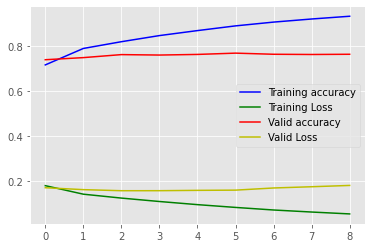

In [ ]:
plot_history(history)

In [ ]:
# check if the model with the cosine similarity performs better than the base one
f1_cos = F1_score(model_cos,[claim_val,evidence_val],best_merging + " with cosine")

if f1_cos > best_f1_score:
    best_f1_score = f1_cos
    best_model = model_cos
    best_model_name = 'model_cos'
    print('The model with cosine similarity implementation has the best performance on the validation set')
else:
    print('The model with cosine similarity implementation has not improved the performance on the validation set ')

concat with cosine model's F1 Macro score: 0.7620
The model with cosine similarity implementation has the best performance on the validation set


Final evaluation of the best model on the test set

In [ ]:
y_pred = best_model.predict([claim_test,evidence_test])
out = [1 if x>=0.5 else 0 for x in y_pred]

In [ ]:
f1_macro_score = f1_score(y_test, out, labels=[0,1], average="macro", zero_division=0)
print("{} model's F1 Macro score: {:.4f}".format(best_model_name, f1_macro_score))

model_cos model's F1 Macro score: 0.7395


In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy score: {:.4f}".format(accuracy_score(y_test,out,normalize = True)))

Accuracy score: 0.7421


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, out, labels=[0,1], zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.64      0.71      3583
           1       0.70      0.84      0.77      3606

    accuracy                           0.74      7189
   macro avg       0.75      0.74      0.74      7189
weighted avg       0.75      0.74      0.74      7189



# Classification
Considering the whole evidence set to classify a claim, we can notice how the results of the model are comparable to the ones obtained without using the major voting.

In [ ]:
def preprocess_input(claim, evidences, word_index, max_len):
  """Preprocess the input in order to pass them to the model.
  Args:
      claim: claim.
      evidences: the list of evidences for the given claim.
      word_index: the vocabulary.
      max_len: max sentence length.
  Returns:
      The padded claim and evidences.
  """
  # Input as text, output as tokenized padded lists of words
  claim = tokenizer.texts_to_sequences([claim])
  evidences = [tokenizer.texts_to_sequences([evidence]) for evidence in evidences]
  claim_pad = pad_sequences(claim, maxlen=max_len)
  evidences_pad =  [pad_sequences(evidence, maxlen=max_len) for evidence in evidences]
  return claim_pad, evidences_pad

In [ ]:
def check_claim(model, claim, evidences, max_len):
  """Aggregate the votes with a majority scheme for final prediction.
  Args:
      model: the model.
      claim: claim.
      evidences: the list of evidences for the given claim.
      max_len: max sentence length.
  Returns:
      The result of the majority scheme (0 = REFUTES, 1 = SUPPORTS).
  """
  votes = []
  claim, evidences = preprocess_input(claim, evidences, word_index, max_len)
  for i, evidence in enumerate(evidences):
    out = model.predict([claim, evidence])
    votes.append(int(np.around(out)))
  zero_counts = votes.count(0)
  one_counts = votes.count(1)
  if one_counts >= zero_counts:
    return 1
  return 0

In [ ]:
# Predict on test set
unique_claims = test_data.groupby('ID').agg('count').sort_values(ascending = False,by = 'Claim')

# We retrieve claims by their ID and then find all the related evidences
IDs = list(unique_claims.index)
y_pred = []
y = []
for claim_id in IDs:
  df = test_data.loc[test_data["ID"]==claim_id]
  claim = df.iloc[0]['Claim']
  y.append(df.iloc[0]['Label'])
  evidences = []
  for i in range(len(df)):
    evidences.append(df.iloc[0]['Evidence'])
  pred = check_claim(best_model, claim, evidences, max_len_test)
  y_pred.append(pred)

In [ ]:
from sklearn.metrics import classification_report
y_true = np.asarray([1 if label=='SUPPORTS' else 0 for label in y])
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.65      0.72      3304
           1       0.71      0.84      0.77      3309

    accuracy                           0.74      6613
   macro avg       0.75      0.74      0.74      6613
weighted avg       0.75      0.74      0.74      6613



# Experiments

## Use all the evidences of a claim in the training

  INTUITION: we observed that the dataset defined as it is labels multiple pairs
  of (claim, evidence) belonging to the same set, i.e. the pairs where the claim
  is the same for all the evidences, with the same label, even if the label 
  represents a unified verification over the entire set of evidences.
  This raises problems like labelling a pair as SUPPORTS even if the evidence isn't
  supporting the claim, but the claim is supported by another evidence.
  This can confuse the classifier during the training, so we tried to slightly 
  modify the dataset.
  
  We group together in the same string all the evidences having the same claim. 
  We keep the test set as it is since the evaluation is done already considering 
  all evidences.
  The max_len variable will increase, leading to more padding on single evidences.
  The results show that there is just a small improvement on this dataset because the number of claims with multiple evidences is just a small portion. It could be interesting to test this idea on other datasets.


### Preprocessing

In [ ]:
# group all the evidences of the same claim
train_data_unified = train_data.copy()
train_data_unified = train_data_unified.groupby(['ID', 'Claim', 'Label'], as_index = False).agg({'Evidence': '. '.join})

val_data_unified = val_data.copy()
val_data_unified = val_data_unified.groupby(['ID', 'Claim', 'Label'], as_index = False).agg({'Evidence': '. '.join})

# Create new vocabulary (including "." character)
df = pd.concat([train_data_unified, val_data_unified, test_data])
text = df['Claim'].append( df['Evidence'], ignore_index=True)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)    
word_index = tokenizer.word_index
vocab_size = len(word_index)

# substitute words with their indexes
claim_sentences_train = tokenizer.texts_to_sequences(train_data_unified.Claim)
evidence_sentences_train = tokenizer.texts_to_sequences(train_data_unified.Evidence)

claim_sentences_val = tokenizer.texts_to_sequences(val_data_unified.Claim)
evidence_sentences_val = tokenizer.texts_to_sequences(val_data_unified.Evidence)

claim_sentences_test = tokenizer.texts_to_sequences(test_data.Claim)
evidence_sentences_test = tokenizer.texts_to_sequences(test_data.Evidence)

# padding
max_len_train = max(find_max_list(evidence_sentences_train), find_max_list(claim_sentences_train))
max_len_val = max(find_max_list(evidence_sentences_val), find_max_list(claim_sentences_val))
max_len_test = max(find_max_list(evidence_sentences_test), find_max_list(claim_sentences_test))

claim_train = pad_sequences(claim_sentences_train, maxlen=max_len_train)
evidence_train = pad_sequences(evidence_sentences_train, maxlen=max_len_train)

claim_val = pad_sequences(claim_sentences_val, maxlen=max_len_val)
evidence_val = pad_sequences(evidence_sentences_val, maxlen=max_len_val)

claim_test = pad_sequences(claim_sentences_test, maxlen=max_len_test)
evidence_test = pad_sequences(evidence_sentences_test, maxlen=max_len_test)

# Create embedding matrix
embedding_matrix = build_embedding_matrix(word_index)

Total OOV terms: 6857 (17.40%)


### Model and training

In [ ]:
# balancing the traing dataset

over = RandomOverSampler()
y_train = np.asarray([1 if label=='SUPPORTS' else 0 for label in train_data_unified.Label])
X_train = np.concatenate((claim_train, evidence_train), axis = -1)
X_train, y_train = over.fit_resample(X_train, y_train)

claim_train = X_train[:,:max_len_train]
evidence_train = X_train[:,max_len_train:]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# get model
model = get_model("rnn", cosine=True)

# compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics= ['acc'])

# check summary of the model
model.summary()

# process labels
y_val   = np.asarray([1 if label=='SUPPORTS' else 0 for label in val_data_unified.Label])
y_test  = np.asarray([1 if label=='SUPPORTS' else 0 for label in test_data.Label])

# Training
history = model.fit([claim_train, evidence_train], y_train, batch_size=1024, epochs=10, verbose=1,
                    validation_data = ([claim_val, evidence_val], y_val),callbacks = callback)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, None, 200)    7879800     input_21[0][0]                   
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, None, 200)    7879800     input_22[0][0]                   
____________________________________________________________________________________________

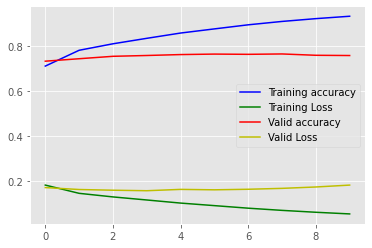

In [ ]:
plot_history(history)

### Evaluation

In [ ]:
# MULTILABEL CLASSIFICATION: predict on test set
y_pred = model.predict([claim_test,evidence_test])
out = [1 if x>=0.5 else 0 for x in y_pred]

# results
report = classification_report(y_test, out, labels=[0,1], zero_division=0)
print("Multi label classification")
print(report)
print()
# CLAIM VERIFICATION: predict on test set
unique_claims = test_data.groupby('ID').agg('count').sort_values(ascending = False,by = 'Claim')
# We retrieve claims by their ID and then find all the related evidences
IDs = list(unique_claims.index)
y_pred = []
y = []
# this may take a while...
for claim_id in IDs:
  df = test_data.loc[test_data["ID"]==claim_id]
  claim = df.iloc[0]['Claim']
  y.append(df.iloc[0]['Label'])
  evidences = []
  for i in range(len(df)):
    evidences.append(df.iloc[0]['Evidence'])
  pred = check_claim(model, claim, evidences, max_len_test)
  y_pred.append(pred)

y_true = np.asarray([1 if label=='SUPPORTS' else 0 for label in y])
print("Classification considering all evidences")
print(classification_report(y_true, y_pred))

Multi label classification
              precision    recall  f1-score   support

           0       0.80      0.64      0.71      3583
           1       0.70      0.84      0.77      3606

    accuracy                           0.74      7189
   macro avg       0.75      0.74      0.74      7189
weighted avg       0.75      0.74      0.74      7189


Classification considering all evidences
              precision    recall  f1-score   support

           0       0.80      0.64      0.71      3304
           1       0.70      0.84      0.76      3309

    accuracy                           0.74      6613
   macro avg       0.75      0.74      0.74      6613
weighted avg       0.75      0.74      0.74      6613



## Pretrained transformers for encoding

By using transformers we have noticed clear improvements especially when we fine tune them on our dataset.

In [ ]:
# This framework provides an easy method to compute dense vector representations for sentences and paragraphs (also known as sentence embeddings).
# The models are based on transformer networks like BERT / RoBERTa / XLM-RoBERTa etc. and are tuned specificially meaningul sentence embeddings
# such that sentences with similar meanings are close in vector space.
!pip install sentence-transformers

     |████████████████████████████████| 71kB 6.5MB/s 
     |████████████████████████████████| 1.3MB 11.7MB/s 
     |████████████████████████████████| 890kB 45.8MB/s 
     |████████████████████████████████| 1.1MB 48.2MB/s 
     |████████████████████████████████| 2.9MB 46.1MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.9-cp36-none-any.whl size=101035 sha256=e9fd6385c5a2d6b88423b71d6c007b3d1f9dec9dc1184eb84fc123d652d930bf
  Stored in directory: /root/.cache/pip/wheels/fc/89/43/f2f5bc00b03ef9724b0f6254a97eaf159a4c4ddc024b33e07a
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=37b391f70281e8ff95a38f8a0d07515c5939e86429123cd770703c0edf884d6b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In [ ]:
from sentence_transformers import SentenceTransformer

device = "cuda" if tf.test.gpu_device_name() == "/device:GPU:0" else "cpu"

# Load a pretrained model

#sentence_transformer = SentenceTransformer('roberta-large-nli-mean-tokens')
#sentence_transformer = SentenceTransformer('roberta-base-nli-mean-tokens')
#sentence_transformer = SentenceTransformer('bert-large-nli-mean-tokens')
sentence_transformer = SentenceTransformer('distilbert-base-nli-mean-tokens', device=device)
#sentence_transformer = SentenceTransformer('bert-base-nli-mean-tokens')
#sentence_transformer = SentenceTransformer('xlm-r-paraphrase-v1')
#sentence_transformer = SentenceTransformer('distilroberta-base-paraphrase-v1')

sentence_embedding_dimension = sentence_transformer.get_sentence_embedding_dimension()

100%|██████████| 245M/245M [00:26<00:00, 9.16MB/s]


In [ ]:
def get_encoding(sentence_transformer):
  """Function to get the claim and evidences encoding.
  Args:
      sentence_transformer: a transformer.

  Returns:
      Claims and evidences encoding.
  """
  print("Encoding the Claims of the Training set")
  claim_encode_train = sentence_transformer.encode(train_data.Claim, show_progress_bar=True)
  print("Encoding the Evidences of the Training set")
  evidence_encode_train = sentence_transformer.encode(train_data.Evidence, show_progress_bar=True)

  print("Encoding the Claims of the Validation set")
  claim_encode_val =  sentence_transformer.encode(val_data.Claim, show_progress_bar=True)
  print("Encoding the Evidences of the Validation set")
  evidence_encode_val = sentence_transformer.encode(val_data.Evidence, show_progress_bar=True)

  print("Encoding the Claims of the Test set")
  claim_encode_test =  sentence_transformer.encode(test_data.Claim, show_progress_bar=True)
  print("Encoding the Evidences of the Test set")
  evidence_encode_test = sentence_transformer.encode(test_data.Evidence, show_progress_bar=True)

  return claim_encode_train, evidence_encode_train, claim_encode_val, evidence_encode_val, claim_encode_test, evidence_encode_test

claim_encode_train, evidence_encode_train, claim_encode_val, evidence_encode_val, claim_encode_test, evidence_encode_test = get_encoding(sentence_transformer)

Encoding the Claims of the Training set



Encoding the Evidences of the Training set



Encoding the Claims of the Validation set



Encoding the Evidences of the Validation set



Encoding the Claims of the Test set



Encoding the Evidences of the Test set


In [ ]:
def get_model_transformers(embedding_dim,  merging="concat", cosine=False):
  """Function used to build the model according to the chosen strategies.
  Args:
      embedding_dim: Embedding dimension used by the transformer.
      merging: Name of the merging strategy.
      cosine: Boolean to indicate wether using the cosine similarity feature. 

  Returns:
      The model.
  """
  claim_encode = Input(shape=(embedding_dim,))
  evidence_encode = Input(shape=(embedding_dim,))
  if cosine:
    cosine_similarity = Dot(axes = 1,normalize = True)([claim_encode,evidence_encode]) 

  # merging
  if merging.strip().lower() == "concat":
    encode = Concatenate()([claim_encode, evidence_encode])

  elif merging.strip().lower() == "sum":
    encode = Add()([claim_encode, evidence_encode])

  elif merging.strip().lower() == "avg":
    encode = Average()([claim_encode, evidence_encode])

  else:
   raise AttributeError("Unsupported merging method! Available ones: concat, sum, avg")

  
  if cosine:
    encode = Concatenate()([encode,cosine_similarity])
  
  # classifier
  outputs = Dense(64, activation='relu')(encode)
  outputs = Dense(1, activation='sigmoid')(outputs)

  # create the model
  model = Model(inputs=[claim_encode, evidence_encode], outputs=outputs)

  return model


# get the model
model = get_model_transformers(sentence_embedding_dimension)

# compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics= ['acc'])

# check summary of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 768)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1536)         0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           98368       concatenate[0][0]            

In [ ]:
# balancing the encoding

over = RandomOverSampler()

y_train = np.asarray([1 if label=='SUPPORTS' else 0 for label in train_data.Label])

X_train = np.concatenate((claim_encode_train, evidence_encode_train), axis = -1)
X_train, y_train = over.fit_resample(X_train, y_train)

claim_encode_train = X_train[:,:sentence_embedding_dimension]
evidence_encode_train = X_train[:,sentence_embedding_dimension:]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
history = model.fit([claim_encode_train, evidence_encode_train], y_train, batch_size=32, epochs=10, verbose=1,
                    validation_data = ([claim_encode_val, evidence_encode_val], y_val),callbacks = callback)

Epoch 1/10
5587/5587 [==============================] - 14s 2ms/step - loss: 0.1511 - acc: 0.7704 - val_loss: 0.1502 - val_acc: 0.7717
Epoch 2/10
5587/5587 [==============================] - 12s 2ms/step - loss: 0.1230 - acc: 0.8226 - val_loss: 0.1437 - val_acc: 0.7867
Epoch 3/10
5587/5587 [==============================] - 13s 2ms/step - loss: 0.1109 - acc: 0.8426 - val_loss: 0.1471 - val_acc: 0.7898
Epoch 4/10
5587/5587 [==============================] - 12s 2ms/step - loss: 0.1039 - acc: 0.8553 - val_loss: 0.1451 - val_acc: 0.7908
Epoch 5/10
5587/5587 [==============================] - 13s 2ms/step - loss: 0.0972 - acc: 0.8679 - val_loss: 0.1480 - val_acc: 0.7895
Epoch 6/10
5587/5587 [==============================] - 12s 2ms/step - loss: 0.0908 - acc: 0.8767 - val_loss: 0.1459 - val_acc: 0.7985
Epoch 7/10
5587/5587 [==============================] - 12s 2ms/step - loss: 0.0863 - acc: 0.8847 - val_loss: 0.1527 - val_acc: 0.7939
Epoch 8/10
5587/5587 [==============================] -

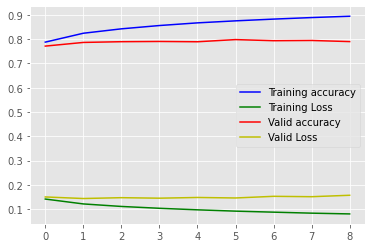

In [ ]:
plot_history(history)

In [ ]:
def check_claim(model, claim, evidences):
  """Aggregate the votes with a majority scheme for final prediction.
  Args:
      model: the model.
      claim: claim.
      evidences: the list of evidences for the given claim.
  Returns:
      The result of the majority scheme (0 = REFUTES, 1 = SUPPORTS).
  """
  votes = []
  for i, evidence in enumerate(evidences):
    out = model.predict([claim[np.newaxis, ...], evidence[np.newaxis, ...]])
    votes.append(int(np.around(out)))
  zero_counts = votes.count(0)
  one_counts = votes.count(1)
  if one_counts >= zero_counts:
    return 1
  return 0

In [ ]:
# Predict on test set
unique_claims = test_data.groupby('ID').agg('count').sort_values(ascending = False,by = 'Claim')

# We retrieve claims by their ID and then find all the related evidences
IDs = list(unique_claims.index)
y_pred = []
y = []
for claim_id in IDs:
  df = test_data.loc[test_data["ID"]==claim_id]
  claim = df.iloc[0]['Claim']
  y.append(df.iloc[0]['Label'])
  evidences = []
  for i in range(len(df)):
    evidences.append(sentence_transformer.encode(df.iloc[0]['Evidence']))
  claim = sentence_transformer.encode(claim)
  pred = check_claim(model, claim, evidences)
  y_pred.append(pred)

In [ ]:
from sklearn.metrics import classification_report
y_true = np.asarray([1 if label=='SUPPORTS' else 0 for label in y])
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.72      0.77      3304
           1       0.75      0.83      0.79      3309

    accuracy                           0.78      6613
   macro avg       0.78      0.78      0.78      6613
weighted avg       0.78      0.78      0.78      6613



### Fine Tuning


In [ ]:
from sentence_transformers import models, losses
from sentence_transformers import SentencesDataset, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator


# You can specify any huggingface/transformers pre-trained model here, for example, bert-base-uncased, roberta-base, xlm-roberta-base
#model_name = 'bert-base-uncased'
#model_name = 'roberta-base'
model_name = 'distilbert-base-uncased'

# Read the dataset
train_batch_size = 16


model_save_path = 'output/training_nli_'+model_name.replace("/", "-")


# Use Huggingface/transformers model (like BERT, RoBERTa, XLNet, XLM-R) for mapping tokens to embeddings
word_embedding_model = models.Transformer(model_name)

# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=True,
                               pooling_mode_cls_token=False,
                               pooling_mode_max_tokens=False)

sentence_transformer = SentenceTransformer(modules=[word_embedding_model, pooling_model], device=device)


In [ ]:
import math
from torch.utils.data import DataLoader
from sentence_transformers.evaluation import SentenceEvaluator

# Read the training dataset

label2int = {"REFUTES": 0, "SUPPORTS": 1}
train_samples = []

for i, _ in enumerate(train_data.Claim):
    label_id = label2int[train_data['Label'].iloc[i]]
    train_samples.append(InputExample(texts=[train_data['Claim'].iloc[i], train_data['Evidence'].iloc[i]], label=label_id))


train_dataset = SentencesDataset(train_samples, model=sentence_transformer)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

sentence_embedding_dimension = sentence_transformer.get_sentence_embedding_dimension()
train_loss = losses.SoftmaxLoss(model=sentence_transformer, sentence_embedding_dimension=sentence_embedding_dimension, num_labels=len(label2int))


# Configure the training
num_epochs = 3

warmup_steps = math.ceil(len(train_dataset) * num_epochs / train_batch_size * 0.1) #10% of train data for warm-up

evaluator = SentenceEvaluator()

# Train the model
sentence_transformer.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps
          )


In [ ]:
#save the model
sentence_transformer.save(model_save_path)

In [ ]:
# load the saved model
#sentence_transformer = SentenceTransformer(model_save_path, device=device)

In [ ]:
claim_encode_train, evidence_encode_train, claim_encode_val, evidence_encode_val, claim_encode_test, evidence_encode_test = get_encoding(sentence_transformer)

# get the model
model = get_model_transformers(sentence_embedding_dimension)

# compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics= ['acc'])

# check summary of the model
model.summary()

Encoding the Claims of the Training set



Encoding the Evidences of the Training set



Encoding the Claims of the Validation set



Encoding the Evidences of the Validation set



Encoding the Claims of the Test set



Encoding the Evidences of the Test set



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 768)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 768)]        0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1536)         0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           98368       concatenate_1[0][0]       

In [ ]:
# balancing the encoding

over = RandomOverSampler()
y_train = np.asarray([1 if label=='SUPPORTS' else 0 for label in train_data.Label])
X_train = np.concatenate((claim_encode_train, evidence_encode_train), axis = -1)
X_train, y_train = over.fit_resample(X_train, y_train)

claim_encode_train = X_train[:,:sentence_embedding_dimension]
evidence_encode_train = X_train[:,sentence_embedding_dimension:]


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
history = model.fit([claim_encode_train, evidence_encode_train], y_train, batch_size=32, epochs=10, verbose=1,
                    validation_data = ([claim_encode_val, evidence_encode_val], y_val),callbacks = callback)

Epoch 1/10
5587/5587 [==============================] - 12s 2ms/step - loss: 0.0496 - acc: 0.9334 - val_loss: 0.1276 - val_acc: 0.8433
Epoch 2/10
5587/5587 [==============================] - 12s 2ms/step - loss: 0.0353 - acc: 0.9559 - val_loss: 0.1266 - val_acc: 0.8444
Epoch 3/10
5587/5587 [==============================] - 12s 2ms/step - loss: 0.0313 - acc: 0.9611 - val_loss: 0.1270 - val_acc: 0.8448
Epoch 4/10
5587/5587 [==============================] - 12s 2ms/step - loss: 0.0288 - acc: 0.9655 - val_loss: 0.1313 - val_acc: 0.8423
Epoch 5/10
5587/5587 [==============================] - 12s 2ms/step - loss: 0.0267 - acc: 0.9678 - val_loss: 0.1290 - val_acc: 0.8448
Epoch 6/10
5587/5587 [==============================] - 12s 2ms/step - loss: 0.0247 - acc: 0.9708 - val_loss: 0.1349 - val_acc: 0.8427


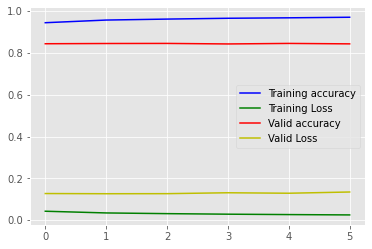

In [ ]:
plot_history(history)

In [ ]:
# Predict on test set
unique_claims = test_data.groupby('ID').agg('count').sort_values(ascending = False,by = 'Claim')

# We retrieve claims by their ID and then find all the related evidences
IDs = list(unique_claims.index)
y_pred = []
y = []
for claim_id in IDs:
  df = test_data.loc[test_data["ID"]==claim_id]
  claim = df.iloc[0]['Claim']
  y.append(df.iloc[0]['Label'])
  evidences = []
  for i in range(len(df)):
    evidences.append(sentence_transformer.encode(df.iloc[0]['Evidence']))
  claim = sentence_transformer.encode(claim)
  pred = check_claim(model, claim, evidences)
  y_pred.append(pred)

In [ ]:
from sklearn.metrics import classification_report
y_true = np.asarray([1 if label=='SUPPORTS' else 0 for label in y])
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      3304
           1       0.79      0.89      0.84      3309

    accuracy                           0.83      6613
   macro avg       0.83      0.83      0.83      6613
weighted avg       0.83      0.83      0.83      6613



Overall, BERT encoding implementation, trained on our dataset led to the best results.

# Credits

Jia Liang Zhou: jialiang.zhou@studio.unibo.it

Simone Gayed Said : simone.gayed@studio.unibo.it

Alex Rossi: alex.rossi6@studio.unibo.it

Hanying Zhang: hanying.zhang@studio.unibo.it

